In [ ]:
!pip3 install -U scikit-learn==1.3.2 pandas==2.0.3 torch==2.4.1 matplotlib requests

In [52]:
import requests
import pandas as pd

from numpy import mean
from numpy import std

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

In [53]:
r = requests.get("https://raw.githubusercontent.com/BackofenLab/MLLS-exercise-SS22/main/week_2/ELAVL1_PARCLIP", allow_redirects=True)
open('ELAVL1_PARCLIP', 'wb').write(r.content)

918890

In [54]:
########################################
##### DATA PARSING / PREPROCESSING #####
########################################

# list of all possible three-mers
three_mers = [  # AAA, AAC, AAG ...
    f"{a}{b}{c}"
    for a in ["A", "C", "U", "G"]
    for b in ["A", "C", "U", "G"]
    for c in ["A", "C", "U", "G"]
]

# get data, one list element per entry1
with open("ELAVL1_PARCLIP") as f:
    data_text = f.read().split("\n>")

data = []
# parse all data elements to get target variable and counts for k-mers
for datum_text in data_text:
    datum = {"target": datum_text.split("\n")[0].split("|")[-1]}
    seq = datum_text.split("\n")[-1]
    for three_mer in three_mers:
        datum[three_mer] = seq.count(three_mer)
    data.append(datum)

# convert to pandas dataframe
df = pd.DataFrame(data)
df

,target,AAA,AAC,AAU,AAG,ACA,ACC,ACU,ACG,AUA,...,GCU,GCG,GUA,GUC,GUU,GUG,GGA,GGC,GGU,GGG
0,1,3,0,3,1,2,3,0,0,1,...,0,0,0,1,2,0,2,0,1,1
1,0,3,1,4,1,2,1,1,0,4,...,1,0,1,0,1,3,3,0,2,0
2,0,2,3,1,0,3,2,0,0,1,...,1,0,1,1,2,0,1,1,0,0
3,0,1,2,1,4,1,2,0,0,1,...,1,0,1,0,0,1,3,1,0,0
4,1,2,0,5,0,1,0,1,0,2,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,1,0,1,0,1,3,2,0,1,...,3,1,1,1,0,0,0,2,2,2
9996,0,3,4,4,1,3,0,1,0,2,...,1,0,0,0,1,2,0,2,2,0
9997,0,2,0,1,2,3,1,2,0,3,...,0,0,3,0,0,1,0,0,1,0
9998,0,1,1,0,1,0,3,1,0,0,...,3,0,0,1,1,2,1,3,2,2


In [55]:
########################################
############# BUILD MODELS #############
########################################

# do test/train split
X = df.iloc[:, 1:]
y = df["target"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=100
)

# random forest fitting
rfc = RandomForestClassifier(n_estimators=200, random_state=100)
rfc.fit(X_train, y_train)

# random forest metrics
rfc_predictions = rfc.predict(X_test)
print("Metrics for random forest:")
print(f"AUROC: {metrics.roc_auc_score(y_test, rfc_predictions)}")
print(f"Accuracy: {metrics.accuracy_score(y_test, rfc_predictions)}")
print(f"Precision: {metrics.precision_score(y_test, rfc_predictions)}")
print(f"Recall: {metrics.recall_score(y_test, rfc_predictions)}")
print(f"F1: {metrics.f1_score(y_test, rfc_predictions)}")
print("\n\n")

# logistic regression fitting
lr = LogisticRegression()
lr.fit(X_train, y_train)

# logistic regression metrics
lr_predictions = lr.predict(X_test)
print("Metrics for logistic regression:")
print(f"AUROC: {metrics.roc_auc_score(y_test, lr_predictions)}")
print(f"Accuracy: {metrics.accuracy_score(y_test, lr_predictions)}")
print(f"Precision: {metrics.precision_score(y_test, lr_predictions)}")
print(f"Recall: {metrics.recall_score(y_test, lr_predictions)}")
print(f"F1: {metrics.f1_score(y_test, lr_predictions)}")
print("\n\n")

# now with cross-validation
cv = KFold(n_splits=5, random_state=1, shuffle=True)
lr = LogisticRegression()
scores = cross_validate(
    lr,
    X,
    y,
    scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],
    cv=cv,
    n_jobs=-1,
)

# logistic regression metrics with cross-validation
print("Metrics for logistic regression with cross validation (mean, stdev):")
print(f"AUROC: {mean(scores['test_roc_auc'])}, {std(scores['test_roc_auc'])}")
print(f"Accuracy: {mean(scores['test_accuracy'])}, {std(scores['test_accuracy'])}")
print(f"Precision: {mean(scores['test_precision'])}, {std(scores['test_precision'])}")
print(f"Recall: {mean(scores['test_recall'])}, {std(scores['test_recall'])}")
print(f"F1: {mean(scores['test_f1'])}, {std(scores['test_f1'])}")

Metrics for random forest:
AUROC: 0.793
Accuracy: 0.793
Precision: 0.7704615384615384
Recall: 0.8346666666666667
F1: 0.8012799999999999





/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics for logistic regression:
AUROC: 0.7869999999999999
Accuracy: 0.787
Precision: 0.7750798722044728
Recall: 0.8086666666666666
F1: 0.7915171288743883





/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Metrics for logistic regression with cross validation (mean, stdev):
AUROC: 0.8648913995420264, 0.006137657594141489
Accuracy: 0.7897000000000001, 0.00815843122174846
Precision: 0.7789708669606296, 0.011594326204471235
Recall: 0.8093718724722503, 0.010870097923967032
F1: 0.7937686021137271, 0.006203942605169041


## Multi-layer perceptron

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=100
)

# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 64  # Number of neurons in the hidden layer
output_size = 2  # Number of output classes (e.g., for classification)
learning_rate = 0.001
batch_size = 128
epochs = 5

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        # Define the first fully connected layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        # Define the output layer
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Pass input through the first layer and apply ReLU activation
        x = F.relu(self.fc1(x))
        # Pass the result through the output layer
        x = self.fc2(x)
        return x

X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float)

y_train = torch.tensor(y_train.to_numpy(), dtype=torch.long)

X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.long)

# Create a DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the MLP model
model = MLP(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

# Function to evaluate the model on the test set
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    all_labels = []
    all_preds = []
    all_probs = []  # For AUROC calculation
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())
            all_probs.extend(F.softmax(outputs, dim=1)[:, 1].cpu().numpy())  # Softmax to get probabilities

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    auroc = roc_auc_score(all_labels, all_probs, multi_class='ovo')
    average_test_loss = test_loss / len(test_loader)

    return average_test_loss, accuracy, precision, recall, f1, auroc


# Training loop
for epoch in range(epochs):
    running_train_loss = 0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Compute loss
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    # Calculate average training loss for the epoch
    average_train_loss = running_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    # Evaluate on test data
    print("Evaluating on test data")
    model.eval()  # Set the model to evaluation mode
    average_test_loss, accuracy, precision, recall, f1, auroc = evaluate_model(model, test_loader, criterion)
    print("AUC-ROC:", auroc)
    test_losses.append(average_test_loss)
    
    # Print the losses for each epoch
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {average_train_loss:.4f}, Test Loss: {average_test_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUROC: {auroc:.4f}")

print("Training complete!")

Evaluating on test data
AUC-ROC: 0.864110888888889
Epoch [1/5], Train Loss: 0.5277, Test Loss: 0.4551
Accuracy: 0.7847, Precision: 0.7870, Recall: 0.7847, F1: 0.7842, AUROC: 0.8641
Evaluating on test data
AUC-ROC: 0.8696933333333334
Epoch [2/5], Train Loss: 0.4629, Test Loss: 0.4462
Accuracy: 0.7863, Precision: 0.7865, Recall: 0.7863, F1: 0.7863, AUROC: 0.8697
Evaluating on test data
AUC-ROC: 0.8715693333333334
Epoch [3/5], Train Loss: 0.4537, Test Loss: 0.4429
Accuracy: 0.7920, Precision: 0.7924, Recall: 0.7920, F1: 0.7919, AUROC: 0.8716
Evaluating on test data
AUC-ROC: 0.8726275555555555
Epoch [4/5], Train Loss: 0.4484, Test Loss: 0.4410
Accuracy: 0.7930, Precision: 0.7958, Recall: 0.7930, F1: 0.7925, AUROC: 0.8726
Evaluating on test data
AUC-ROC: 0.8734022222222222
Epoch [5/5], Train Loss: 0.4462, Test Loss: 0.4413
Accuracy: 0.7973, Precision: 0.8022, Recall: 0.7973, F1: 0.7965, AUROC: 0.8734
Training complete!


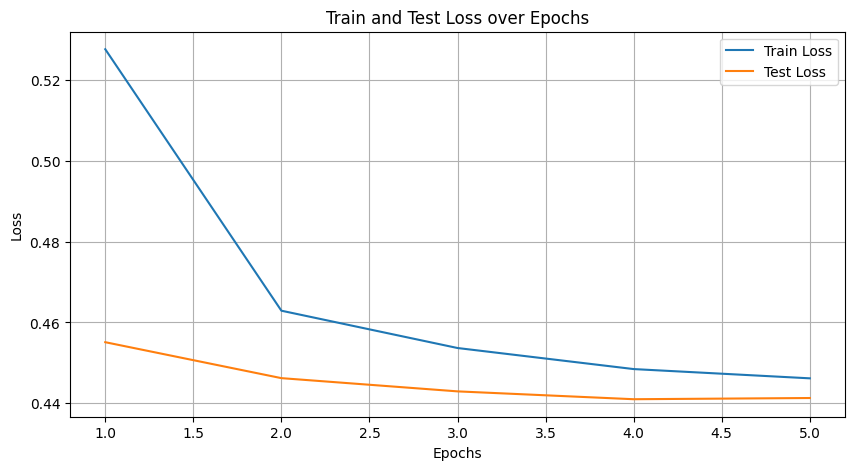

In [65]:
# Plotting the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.title('Train and Test Loss over Epochs')
plt.legend()
plt.show()